# **<h1><center>Exploring the Seattle 2016 Airbnb Data!</center></h1>**

# **1. Bussines Uderstanding**

Airbnb is a platform that can be accessed in search of short, medium and long-term accommodation places, in which people can post their properties and pay a commission to airbnb, in this work we find the information of the properties offered in Seattle in the year 2016.

The data we are going to explore in this notebook was obtained from the Seattle Airbnb Open Data Kaggle site. In this dataset we can found information about the availability, prices, charactheristics of the listed places and about the host of each one of them and reviews from users.

I'm going to implement the CRISP-DM process as part of the project requirements for Udacity's Data Scientist Nanodegree. The CRISP-DM process has six elements:

Business Understanding

1. Data Understanding
2. Data Preparation
3. Modeling
4. Evaluation
5. Deployment

### **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from datetime import datetime
from collections import defaultdict
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import math
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# **2. Data Understanding**

In [2]:
#Import data

# Calendar
df_cal = pd.read_csv('/content/calendar.csv')
# Listings
df_list = pd.read_csv('/content/listings.csv')
# reviews
df_rev = pd.read_csv('/content/reviews.csv')

### **2.1 Calendar**

as we can see in the table below the dataset contains information of the availability lists per id by date and the listing price

In [3]:
df_cal.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


There is some issues in the datatype we can identify fron the info function, the steps we hace to follow are lited next:

* listing_id: convert to `str`
* date: convert to `datetime`
* available: convert to dummy
* price: drop $ and convert to float/int

Aditionaly it is possible to see that the only column with missing values is price.



In [4]:
df_cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


If we explore the possible reasson why the price column has null values we found that this happend because we only have the price of the listed propietries who are avaliable

In [5]:
# Check if number of missing values in the price colum 
df_cal.price.isna().sum() 

459028

In [6]:
# Check if number of missing values in the availability column 
df_cal.isna().groupby([df_cal['available']]).sum()

,listing_id,date,available,price
available,,,,
f,0,0,0,459028
t,0,0,0,0


In [7]:
df_cal_null=df_cal[df_cal['available']=='f']
df_cal_null.head()

,listing_id,date,available,price
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN
5,241032,2016-01-09,f,NaN
6,241032,2016-01-10,f,NaN


### **2.2 Listings**

This dataset has information about the characteristics of the properties, such as the number of rooms, the neighborhood, number of bathrooms as well as certain characteristics of the host such as the response time, its acceptance rate among others

In [8]:
df_list.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,...,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,NaN,NaN,

In [9]:
df_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

There are 92 variables in this dataset and some of them has null values, we check that there are only one row for each property but there are more than one property for each host.

In [10]:
# Check if there are unique Ids
df_list.id.nunique()

3818

In [11]:
# Check number of host ids
df_list.host_id.nunique()

2751

The 85% of the host are located in seattle, but there a lot of places so it willl be dificult to work with this variable as a dummy one.

In [12]:
# Check host locations

df_list['host_location'].value_counts()/df_list.shape[0]

Seattle, Washington, United States         0.853588
US                                         0.064432
Spokane, Washington, United States         0.010739
Kent, Washington, United States            0.008905
Los Angeles, California, United States     0.003405
                                             ...   
Port Orchard, Washington, United States    0.000262
Las Vegas, Nevada, United States           0.000262
Bloomington, Indiana, United States        0.000262
Houston, Texas, United States              0.000262
Arlington, Massachusetts, United States    0.000262
Name: host_location, Length: 120, dtype: float64

In [13]:
# values for city
df_list.city.value_counts()

Seattle                  3810
West Seattle                2
Seattle                     2
Ballard, Seattle            1
西雅图                         1
Phinney Ridge Seattle       1
seattle                     1
Name: city, dtype: int64

In [14]:
# values for acceptance rate
df_list.host_acceptance_rate.value_counts()

100%    3044
0%         1
Name: host_acceptance_rate, dtype: int64

We found 16 levels for the property types so is not that bad to work with this variable as a dummie

In [15]:
# property types
df_list.property_type.value_counts()

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Camper/RV            13
Bungalow             13
Boat                  8
Tent                  5
Treehouse             3
Dorm                  2
Chalet                2
Yurt                  1
Name: property_type, dtype: int64

In [16]:
#room types
df_list.room_type.value_counts()

Entire home/apt    2541
Private room       1160
Shared room         117
Name: room_type, dtype: int64

In [17]:
# cancellation policies
df_list.cancellation_policy.unique()

array(['moderate', 'strict', 'flexible'], dtype=object)

In [18]:
# amenities
df_list.amenities.unique()

array(['{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,Heating,"Family/Kid Friendly",Washer,Dryer}',
       '{TV,Internet,"Wireless Internet",Kitchen,"Free Parking on Premises","Buzzer/Wireless Intercom",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","First Aid Kit","Safety Card","Fire Extinguisher",Essentials}',
       '{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,"Free Parking on Premises","Pets Allowed","Pets live on this property",Dog(s),Cat(s),"Hot Tub","Indoor Fireplace",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector",Essentials,Shampoo}',
       ...,
       '{"Cable TV","Wireless Internet",Kitchen,"Free Parking on Premises",Breakfast,"Pets live on this property",Dog(s),Cat(s),Heating,Washer,Dryer,"Smoke Detector","First Aid Kit","Safety Card","Fire Extinguisher",Essentials,Hangers,"Hair Dryer",Iron,"Laptop Friendly Workspace"}',
       '{TV,"Wireless I

In [19]:
# booking_ratio_30
df_list.availability_30.value_counts()

30    981
0     883
29    141
25    110
27    109
26    102
28     96
20     94
23     93
21     84
24     81
22     80
2      74
16     73
18     72
19     67
3      63
17     60
1      54
10     52
14     51
9      49
8      48
5      48
12     46
15     45
13     45
4      34
6      33
11     27
7      23
Name: availability_30, dtype: int64

In [20]:
# Count the number of nulls in this relevant columns
print('property_type:', df_list['property_type'].isnull().sum())
print('room_type    :', df_list['room_type'].isnull().sum())
print('accommodates :', df_list['accommodates'].isnull().sum())
print('bathrooms    :', df_list['bathrooms'].isnull().sum())
print('bedrooms     :', df_list['bedrooms'].isnull().sum())
print('beds         :', df_list['beds'].isnull().sum())
print('price        :', df_list['price'].isnull().sum())

property_type: 1
room_type    : 0
accommodates : 0
bathrooms    : 16
bedrooms     : 6
beds         : 1
price        : 0


# **3. Data Preparation**

I'm interested is explore the next steps:

*   Conver the variaables to the correct datatype
*   Drop not relevant columns for our project

### **Data Cleaning**

In [21]:
# Remove Dolar sign & Nulls in the price for calendar and listings data
# I decide to remove the properties that does not have price information because i'm interested in analize diferent variables vs the price 
# in the questions i propose for the project and because just the avaliable properties are the one who has this information
df_cal[['price']] = df_cal[['price']].replace('[\$,]','',regex=True).astype(float)
df_cal = df_cal.dropna()

df_list.price = df_list.price.str.replace('$', '').str.replace(',', '')
df_list['price'] = df_list['price'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """


In [22]:
# convert the ID columns into str type
df_cal['listing_id'] = df_cal['listing_id'].astype(str)
df_list['id'] = df_list['id'].astype(str)

In [23]:
# Join the two datasets

df = pd.merge(df_cal, df_list, how='left', left_on='listing_id', right_on='id')
df.drop('listing_id', axis=1, inplace=True)

In [24]:
# convert dato into datatime type
df['date'] = pd.to_datetime(df["date"])

In [25]:
df.head()

,date,available,price_x,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,bedrooms,beds,bed_type,amenities,square_feet,price_y,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2016-01-04,t,85.0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,...,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,85.0,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,2016-01-05,t,85.0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,...,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,85.0,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
2,2016-01-13,t,85.0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,...,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,85

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 934542 entries, 0 to 934541
Data columns (total 95 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   date                              934542 non-null  datetime64[ns]
 1   available                         934542 non-null  object        
 2   price_x                           934542 non-null  float64       
 3   id                                934542 non-null  object        
 4   listing_url                       934542 non-null  object        
 5   scrape_id                         934542 non-null  int64         
 6   last_scraped                      934542 non-null  object        
 7   name                              934542 non-null  object        
 8   summary                           884880 non-null  object        
 9   space                             806422 non-null  object        
 10  description                     

In [27]:
# Drop unnecessary columns

#I create the list of variables i'm not interested 
drop_cols = ['listing_url', 'scrape_id', 'last_scraped', 'experiences_offered',
             'name','summary','space','experiences_offered',
             'neighborhood_overview', 'notes', 'medium_url', 'picture_url', 
             'xl_picture_url', 'host_url', 'host_name', 'host_location', 
             'host_about', 'host_thumbnail_url', 'host_picture_url', 
             'host_neighbourhood', 'host_total_listings_count', 
             'host_verifications', 'street', 'neighbourhood', 'city', 'state', 'zipcode', 
             'market', 'smart_location', 'country_code', 'country', 'price_y',
             'weekly_price', 'monthly_price', 'guests_included', 
             'calendar_updated', 'has_availability', 'calendar_last_scraped', 
             'first_review', 'last_review', 'requires_license', 'license', 
             'jurisdiction_names', 'reviews_per_month', 'square_feet']

df = df.drop(drop_cols, axis=1)

# then i rename the price x to price

df.rename(columns={'price_x': 'price'}, inplace=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 934542 entries, 0 to 934541
Data columns (total 51 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   date                              934542 non-null  datetime64[ns]
 1   available                         934542 non-null  object        
 2   price                             934542 non-null  float64       
 3   id                                934542 non-null  object        
 4   description                       934542 non-null  object        
 5   transit                           711504 non-null  object        
 6   thumbnail_url                     857694 non-null  object        
 7   host_id                           934542 non-null  int64         
 8   host_since                        934450 non-null  object        
 9   host_response_time                826028 non-null  object        
 10  host_response_rate              

The code in the below cell is taken from one of the Udacity lecture notes (named: HowToBreakIntoTheField.py). This function is used to count the number of listings that contains each amenity in the amenities list.

#**4. Data Modelling**

### ***QUESTIONS***





### **1. What time of year has the highest and lowest prices?**

In [29]:
price_for_date = df.groupby(df['date'].dt.strftime('%B'),sort=False)['price'].mean()
price_for_date.head()

date
January     122.912176
February    124.293927
March       128.644488
April       135.097005
May         139.538183
Name: price, dtype: float64

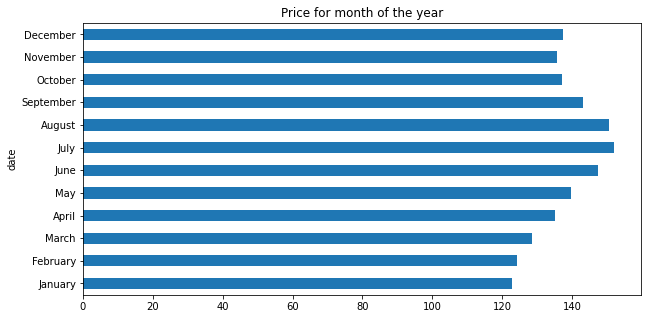

In [30]:
# graphic

price_for_date.plot(kind ='barh',figsize =(10,5));
plt.title('Price for month of the year');
plt.show()

The months in which the properties have the highest prices are june, july, august and september, while the months in which the prices are lowest are january, february and march

### **2. What type of rooms has the highest proportion of reservations in the next 60 days?**

In [31]:
#I'm gonna to use availability_60 to calculate the proportion of reservations
df['availability_60'].isnull().sum()

0

Whith the following code I found the percantage on booking ratio of each listing

In [32]:
#creates the column 'booking_ratio_60' 
df['booking_ratio_60'] = 1 - (df['availability_60']/60)

In [33]:
#Show the first five rows of the new column
df['booking_ratio_60'].head()

0    0.316667
1    0.316667
2    0.316667
3    0.316667
4    0.316667
Name: booking_ratio_60, dtype: float64

In [34]:
#information about booking ratios of different room types for next 30 days
ratio_60=df.groupby(['room_type'])['booking_ratio_60'].mean().sort_values(ascending=False)
ratio_60

room_type
Entire home/apt    0.307441
Private room       0.215429
Shared room        0.140511
Name: booking_ratio_60, dtype: float64

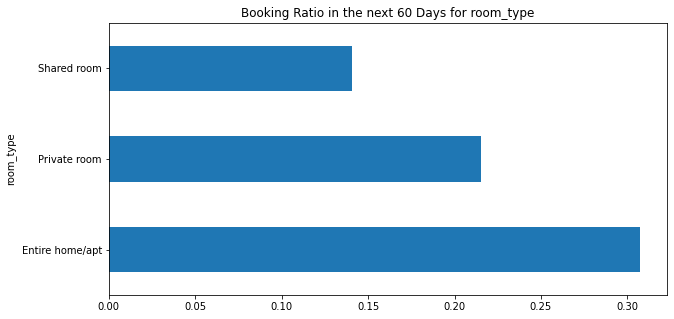

In [35]:
# graphic

ratio_60.plot(kind ='barh',figsize =(10,5));
plt.title('Booking Ratio in the next 60 Days for room_type');
plt.show()

The types of rooms that have a higher percentage of reservations is Entire home/apt with more than 30%, following by priver room with about 21% and finally the shared room with about 14%, it seams like the privet soaces are the most prefered for the guest.

### **3. The number of bedrooms influences the price?**

In [36]:
price_for_rom = df.groupby(df['bedrooms'],sort=True)['price'].mean()
price_for_rom.head()

bedrooms
0.0    112.098814
1.0    101.334197
2.0    198.138838
3.0    288.683781
4.0    327.427955
Name: price, dtype: float64

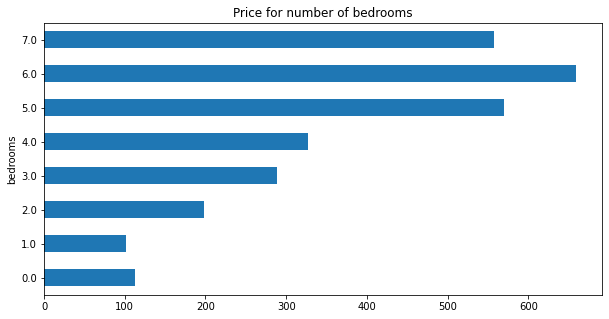

In [37]:
# graphic

price_for_rom.plot(kind ='barh',figsize =(10,5));
plt.title('Price for number of bedrooms');
plt.show()

After seeing how the variables price and number of rooms are related, we find that these variables do not have a linear relationship, that is, it is not the case that the property with a greater number of rooms has a higher average price, in fact we can see in the graph that the properties with 6,7 and 5 rooms tend to be the most expensive on average

### **4. The number of bathrooms influences the price?**

In [38]:
price_for_br = df.groupby(df['bathrooms'],sort=True)['price'].mean()
price_for_br.head()

bathrooms
0.0     69.455312
0.5     75.086867
1.0    113.616777
1.5    135.760129
2.0    216.026485
Name: price, dtype: float64

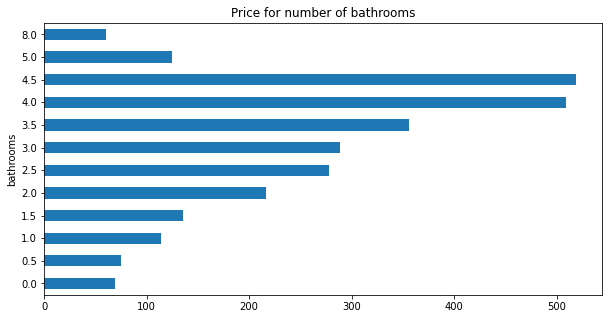

In [39]:
# graphic

price_for_br.plot(kind ='barh',figsize =(10,5));
plt.title('Price for number of bathrooms');
plt.show()

Despite of the relationship between the price and the number of bathrooms, we find that these variables do not have a linear relationship, as we saw with the number of rooms, in this case the properties with a higher average price are those that have four and a half bathrooms and four full bathrooms

### **5. How is the relationship between property type price of them?**

In [40]:
price_for_pt = df.groupby(df['property_type'],sort=True)['price'].mean()
price_for_pt.head()

property_type
Apartment          139.285106
Bed & Breakfast    116.048976
Boat               330.618901
Bungalow           124.330813
Cabin              114.292208
Name: price, dtype: float64

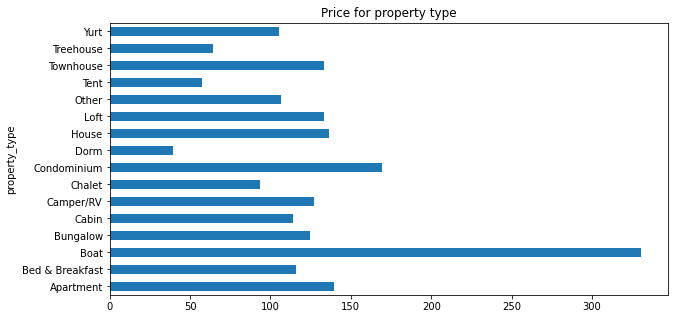

In [41]:
# graphic

price_for_pt.plot(kind ='barh',figsize =(10,5));
plt.title('Price for property type');
plt.show()

The type of property with the highest prices are the boats with prices that far exceed the other categories, while the type of property with the lowest average prices are Dorm, tent and treehouse.

In [42]:
#To create the next table I consult the way to do it in this page: https://jamesrledoux.com/code/group-by-aggregate-pandas
# Create Table of mean of the mean for property type and the bed type ofered by them
price_for= pd.DataFrame(df.groupby(['property_type', 'bed_type']).agg({'price': ['mean']}))
price_for = price_for.reset_index()
print(price_for)

      property_type       bed_type       price
                                          mean
0         Apartment         Airbed   92.535052
1         Apartment          Couch   78.432169
2         Apartment          Futon   74.889750
3         Apartment  Pull-out Sofa  100.502308
4         Apartment       Real Bed  142.356327
5   Bed & Breakfast          Couch   33.871148
6   Bed & Breakfast       Real Bed  119.135508
7              Boat          Couch   75.000000
8              Boat       Real Bed  334.265716
9          Bungalow       Real Bed  124.330813
10            Cabin          Futon   91.170088
11            Cabin       Real Bed  115.955284
12        Camper/RV  Pull-out Sofa   79.321330
13        Camper/RV       Real Bed  132.544089
14           Chalet       Real Bed   93.509009
15      Condominium          Futon  150.000000
16      Condominium  Pull-out Sofa   75.000000
17      Condominium       Real Bed  171.472791
18             Dorm       Real Bed   39.384977
19           

We found that a factor that significantly increases the price is the type of bed, since for all types of properties those with real beds are the most expensive.

### **6. What are the most common amenities in the listings?**


To answer this question, let's see the way in which the information of this variable comes through a frequency table.

In [43]:
#I create a dataframe which has lists of amenities as one column and the count of these amenities 
amenities = df_list['amenities'].value_counts().reset_index()
amenities.rename(columns={'index': 'amenities', 'amenities': 'count'}, inplace=True)
amenities

,amenities,count
0,{},45
1,"{Internet,""Wireless Internet"",Kitchen,""Free Pa...",11
2,"{TV,""Cable TV"",Internet,""Wireless Internet"",Po...",10
3,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",8
4,"{TV,Internet,""Wireless Internet"",""Air Conditio...",7
...,...,...
3279,"{TV,Internet,""Wireless Internet"",""Air Conditio...",1
3280,"{""Cable TV"",""Wireless Internet"",""Air Condition...",1
3281,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1
3282,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",1


As we can see, we have make a little bit of clean in this variable because we have many amenities from single property, to do this, first we have to extract the strings from the {}, then split the text string an finally obtain the counts from every ammenitie to find the aswer to our question 

I want to create a similar proces that we see in the clasroom, first  have to get the list with all the unique amenities of the properties

In [44]:
# Create a fuction to extract a list with the unique amenities
def clean_amenities(df, col):
    
  amenities_list = df[col].str.replace('{', '').str.replace('}', '')
  amenities_list = amenities_list.str.split(',', expand=True).stack()
  amenities_list.append(amenities_list)
  amenities_list_unique = amenities_list.unique()

  '''
    INPUT:
    df - the pandas dataframe you want to search
    col - the column name you want to look through in this case amenities
    
    OUTPUT:
    amenities_list_unique - a list with the unique values for amenities
    '''
  return amenities_list_unique

The function above is a necesary parameter we need to use the function tha we see in the exercise HowToBreakIntoTheField.py, so i took the fuction. This function is used to count the number of listings that contains each amenity in the amenities list.

In [45]:
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of amenities
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the amenity is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

Noaw I use the fuction clean_amenities

In [46]:
posible_vals= clean_amenities(df_list,'amenities')
posible_vals

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.


array(['TV', '"Cable TV"', 'Internet', '"Wireless Internet"',
       '"Air Conditioning"', 'Kitchen', 'Heating',
       '"Family/Kid Friendly"', 'Washer', 'Dryer',
       '"Free Parking on Premises"', '"Buzzer/Wireless Intercom"',
       '"Smoke Detector"', '"Carbon Monoxide Detector"',
       '"First Aid Kit"', '"Safety Card"', '"Fire Extinguisher"',
       'Essentials', '"Pets Allowed"', '"Pets live on this property"',
       'Dog(s)', 'Cat(s)', '"Hot Tub"', '"Indoor Fireplace"', 'Shampoo',
       'Breakfast', '"24-Hour Check-in"', 'Hangers', '"Hair Dryer"',
       'Iron', '"Laptop Friendly Workspace"', '"Suitable for Events"',
       '"Elevator in Building"', '"Lock on Bedroom Door"',
       '"Wheelchair Accessible"', 'Gym', '', 'Pool', '"Smoking Allowed"',
       '"Other pet(s)"', 'Doorman', '"Washer / Dryer"'], dtype=object)

And in this part a use the total couts to get the number of listings that contain each amenity

In [47]:
#Here with the total_count function, I count the number of listings that contains each amenity in the amenities list.
amenities_df = total_count(amenities, 'amenities', 'count', posible_vals)
amenities_df.set_index('amenities', inplace=True)


In [48]:
#Here we drop the null a,enities because this don't bring us any importat information
filtro = amenities_df['count'] < 3818
amenities_df = amenities_df[filtro]

Finally we obtain the results in the next graph, where we can see tha the most common amenities in Seattle are:

* Internet
* Wireless Internet
* Heating
* Smoke Detector
* Essentials

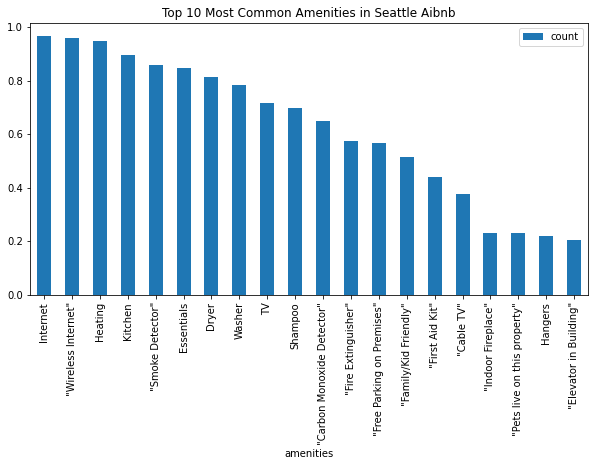

In [49]:
#Here I create a bar chart to show the percentage of each amenity from the most common to the least common.
Common_amenities = (amenities_df/len(df_list))[:20]

Common_amenities.plot(kind='bar',figsize =(10,5));
plt.title('Top 10 Most Common Amenities in Seattle Aibnb');
plt.show()